In [2]:
from datetime import datetime
from math import exp
from collections import defaultdict

# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.special import expit, logit
from scipy.stats.mstats import winsorize
from scipy.interpolate import interp1d, make_interp_spline, BSpline

# Plot data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from IPython.display import HTML, Image, display, Markdown as md

# statsmodels
import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# scikit-learn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# tensorflow
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# warnings
import warnings
warnings.filterwarnings('ignore')

md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

Analysis last performed on 06/14/2022.

## Read `PetFinder` dataset

In [3]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = '/content/datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')

petfinder = pd.read_csv(csv_file)
petfinder.head()

1679360/1668792 [==============================] - 0s 0us/step


,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


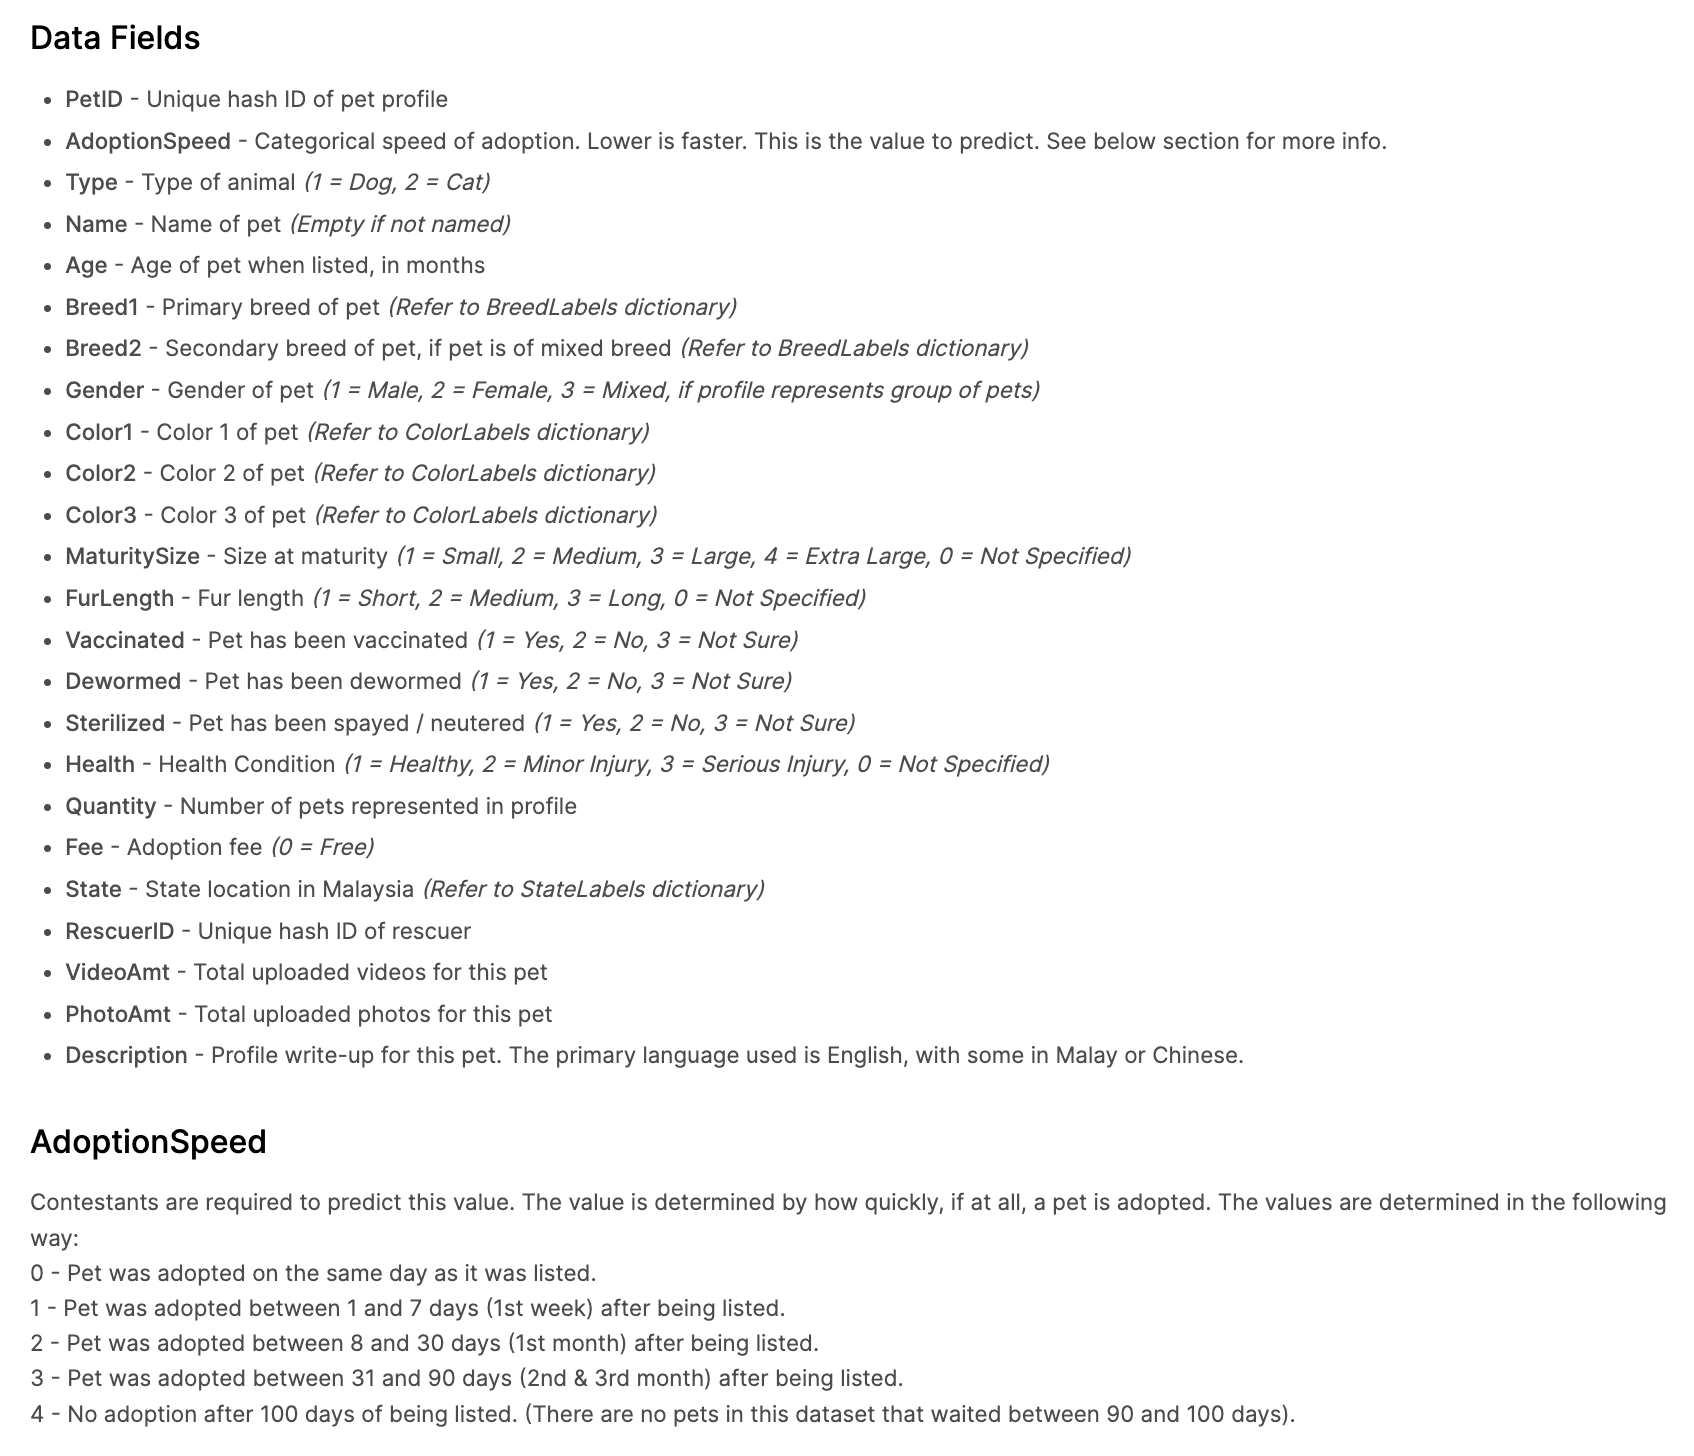

In [ ]:
display(Image('../../images/petfinder_adoption_dataset_description.png', width=900))

## Check data types and values

In [4]:
petfinder.dtypes

Type             object
Age               int64
Breed1           object
Gender           object
Color1           object
Color2           object
MaturitySize     object
FurLength        object
Vaccinated       object
Sterilized       object
Health           object
Fee               int64
Description      object
PhotoAmt          int64
AdoptionSpeed     int64
dtype: object

In [5]:
petfinder.isna().sum()

Type             0
Age              0
Breed1           0
Gender           0
Color1           0
Color2           0
MaturitySize     0
FurLength        0
Vaccinated       0
Sterilized       0
Health           0
Fee              0
Description      9
PhotoAmt         0
AdoptionSpeed    0
dtype: int64

## Create a target variable

In this classification problem, we simply have to predict whether a pet was adopted or not.  After modifying the `AdoptionSpeed` column, `0` will indicate the pet was not adopted, and `1` will indicate it was.

In [6]:
# In the original dataset, 'AdoptionSpeed' of 4 indicates a pet was not adopted.
petfinder['Adopted'] = np.where(petfinder['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
petfinder = petfinder.drop(columns=['AdoptionSpeed', 'Description'])

## Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [7]:
train_petfinder = petfinder.sample(frac=0.8, random_state=0)
test_petfinder  = petfinder.drop(train_petfinder.index)

## Split features from labels

Separate the target value — the "label" — from the features.  This label is the value that you will train the model to predict.

In [8]:
train_features = train_petfinder.copy()
test_features = test_petfinder.copy()

train_labels = train_features.pop('Adopted')
test_labels = test_features.pop('Adopted')

train_features.columns.to_list()

['Type',
 'Age',
 'Breed1',
 'Gender',
 'Color1',
 'Color2',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Sterilized',
 'Health',
 'Fee',
 'PhotoAmt']

In [9]:
train_labels.value_counts()

1    6761
0    2469
Name: Adopted, dtype: int64

In [10]:
test_labels.value_counts()

1    1696
0     611
Name: Adopted, dtype: int64

## Convert categorical predictors into dummy / indicator predictors

In [11]:
categorical_predictors = ['Type', 'Gender', 'Age', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

In [12]:
# train_features['Type'].value_counts()

train_features['Is_Cat'] = np.where(train_features['Type']=='Dog', 0., 1.)

test_features['Is_Cat'] = np.where(test_features['Type']=='Dog', 0., 1.)

In [13]:
# train_features['Gender'].value_counts()

train_features['Is_Female'] = np.where(train_features['Gender']=='Male', 0., 1.)

test_features['Is_Female'] = np.where(test_features['Gender']=='Male', 0., 1.)

In [14]:
# train_features['Vaccinated'].value_counts()

train_features = train_features.join(pd.get_dummies(train_features['Vaccinated'], prefix='Vaccinated'))

test_features = test_features.join(pd.get_dummies(test_features['Vaccinated'], prefix='Vaccinated'))

In [15]:
# train_features['Sterilized'].value_counts()

train_features = train_features.join(pd.get_dummies(train_features['Sterilized'], prefix='Sterilized'))

test_features = test_features.join(pd.get_dummies(test_features['Sterilized'], prefix='Sterilized'))

In [16]:
# train_features['Health'].value_counts()

train_features = train_features.join(pd.get_dummies(train_features['Health'], prefix='Health'))

test_features = test_features.join(pd.get_dummies(test_features['Health'], prefix='Health'))

In [17]:
# train_features['MaturitySize'].unique()

maturity_size_type = CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True)

train_features['MaturitySize'] = train_features['MaturitySize'].astype(maturity_size_type)
test_features['MaturitySize'] =  test_features['MaturitySize'].astype(maturity_size_type)

train_features = train_features.join(pd.get_dummies(train_features['MaturitySize'], prefix='MaturitySize'))
test_features = test_features.join(pd.get_dummies(test_features['MaturitySize'], prefix='MaturitySize'))

In [18]:
# train_features['FurLength'].unique()

fur_length_type = CategoricalDtype(categories=['Short', 'Medium', 'Long'], ordered=True)

train_features['FurLength'] = train_features['FurLength'].astype(fur_length_type)
test_features['FurLength'] =  test_features['FurLength'].astype(fur_length_type)

train_features = train_features.join(pd.get_dummies(train_features['FurLength'], prefix='FurLength'))
test_features = test_features.join(pd.get_dummies(test_features['FurLength'], prefix='FurLength'))

In [19]:
# train_features['Color1'].unique()

train_features = train_features.join(pd.get_dummies(train_features['Color1'], prefix='Color1'))

test_features = test_features.join(pd.get_dummies(test_features['Color1'], prefix='Color1'))

In [20]:
# train_features['Color2'].unique()

train_features = train_features.join(pd.get_dummies(train_features['Color2'], prefix='Color2'))

test_features = test_features.join(pd.get_dummies(test_features['Color2'], prefix='Color2'))

In [21]:
# len(sorted(train_features['Age'].unique()))

ptile_labels = ['ptile1', 'ptile2', 'ptile3', 'ptile4', 'ptile5']

train_features = train_features.join(pd.get_dummies(pd.qcut(train_features['Age'], 
                                                            q=[0, .2, .4, .6, .8, 1], 
                                                            labels=ptile_labels), prefix='Age'))

test_features = test_features.join(pd.get_dummies(pd.qcut(test_features['Age'], 
                                                          q=[0, .2, .4, .6, .8, 1], 
                                                          labels=ptile_labels), prefix='Age'))

In [22]:
# train_features['Breed1'].value_counts()[:20]

keep_breeds = ['Mixed Breed', 'Domestic Short Hair', 'Domestic Medium Hair', 'Tabby', 
               'Domestic Long Hair', 'Siamese', 'Shih Tzu', 'Labrador Retriever', 
               'Persian', 'Poodle', 'Poodle', 'Terrier', 'Golden Retriever']

dd = defaultdict(lambda: 'Other')

for _, breed in enumerate(keep_breeds):
    dd[breed] = breed

train_features['Breed1'].map(dd)

train_features = train_features.join(pd.get_dummies(train_features['Breed1'].map(dd), prefix='Breed1'))

test_features = test_features.join(pd.get_dummies(test_features['Breed1'].map(dd), prefix='Breed1'))

## Standardize numeric predictors

In [23]:
# list(train_features.columns)

predictors = [
#'Type',
#'Age',
#'Breed1',
#'Gender',
#'Color1',
#'Color2',
#'MaturitySize',
#'FurLength',
#'Vaccinated',
#'Sterilized',
#'Health',
'Fee',
'PhotoAmt',
'Is_Cat',
'Is_Female',
#'Vaccinated_No',
'Vaccinated_Not Sure',
'Vaccinated_Yes',
#'Sterilized_No',
'Sterilized_Not Sure',
'Sterilized_Yes',
'Health_Healthy',
'Health_Minor Injury',
#'Health_Serious Injury',
#'MaturitySize_Small',
'MaturitySize_Medium',
'MaturitySize_Large',
#'FurLength_Short',
'FurLength_Medium',
'FurLength_Long',
#'Color1_Black',
'Color1_Brown',
'Color1_Cream',
'Color1_Golden',
'Color1_Gray',
'Color1_White',
'Color1_Yellow',
'Color2_Brown',
'Color2_Cream',
'Color2_Golden',
'Color2_Gray',
#'Color2_No Color',
'Color2_White',
'Color2_Yellow',
'Age_ptile1',
'Age_ptile2',
'Age_ptile3',
'Age_ptile4',
#'Age_ptile5',
'Breed1_Domestic Long Hair',
'Breed1_Domestic Medium Hair',
'Breed1_Domestic Short Hair',
'Breed1_Golden Retriever',
'Breed1_Labrador Retriever',
'Breed1_Mixed Breed',
#'Breed1_Other',
'Breed1_Persian',
'Breed1_Poodle',
'Breed1_Shih Tzu',
'Breed1_Siamese',
'Breed1_Tabby',
'Breed1_Terrier']

train_features = train_features[predictors].copy()
test_features = test_features[predictors].copy()

train_features[predictors] = (train_features[predictors] - train_features[predictors].mean()) / train_features[predictors].std()

test_features[predictors] = (test_features[predictors] - test_features[predictors].mean()) / test_features[predictors].std()

In [24]:
train_features.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
Fee,9230.0,-0.0,1.0,-0.30,-0.30,-0.30,-0.30,24.14
PhotoAmt,9230.0,0.0,1.0,-1.15,-0.51,-0.19,0.44,8.38
Is_Cat,9230.0,-0.0,1.0,-0.86,-0.86,-0.86,1.16,1.16
Is_Female,9230.0,-0.0,1.0,-1.13,-1.13,0.89,0.89,0.89
Vaccinated_Not Sure,9230.0,0.0,1.0,-0.39,-0.39,-0.39,-0.39,2.56
Vaccinated_Yes,9230.0,0.0,1.0,-0.89,-0.89,-0.89,1.13,1.13
Sterilized_Not Sure,9230.0,0.0,1.0,-0.36,-0.36,-0.36,-0.36,2.75
Sterilized_Yes,9230.0,0.0,1.0,-0.56,-0.56,-0.56,-0.56,1.79
Health_Healthy,9230.0,-0.0,1.0,-5.06,0.20,0.20,0.20,0.20
Health_Minor Injury,9230.0,-0.0,1.0,-0.19,-0.19,-0.19,-0.19,5.24


## Logistic regression with one predictor

Begin with a logistic regression to predict `'Adopted'` from `'Fee'`.

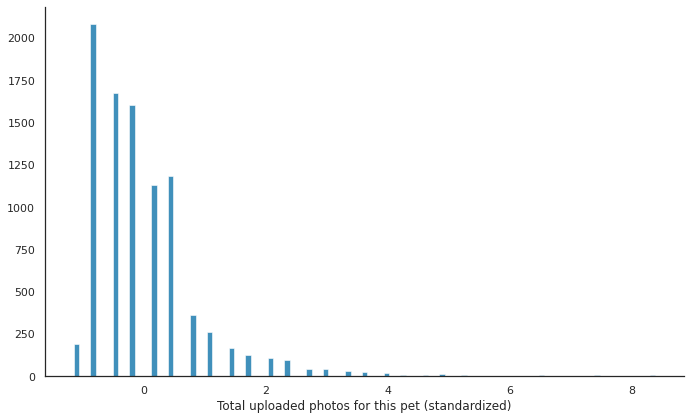

In [ ]:
g = sns.displot(train_features['PhotoAmt'], height=6, aspect=10/6)
g.set_axis_labels('Total uploaded photos for this pet (standardized)', '')
g.set_titles('');

### `statsmodels`

In [25]:
y = train_labels.values

X = train_features['PhotoAmt'].values
X = sm.add_constant(X)

X.shape, y.shape

((9230, 2), (9230,))

In [26]:
y[:5]

array([1, 0, 1, 0, 1])

In [27]:
X[:5]

array([[ 1.        , -0.19333653],
       [ 1.        ,  0.75941104],
       [ 1.        , -0.82850158],
       [ 1.        , -0.51091906],
       [ 1.        , -0.51091906]])

In [ ]:
# Describe model
m1_sm = sm.Logit(y, X)

# Fit model
res_sm = m1_sm.fit()

# Summarize model
print(res_sm.summary())

Optimization terminated successfully.
         Current function value: 0.574561
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 9230
Model:                          Logit   Df Residuals:                     9228
Method:                           MLE   Df Model:                            1
Date:                Tue, 07 Jun 2022   Pseudo R-squ.:                 0.01066
Time:                        05:10:19   Log-Likelihood:                -5303.2
converged:                       True   LL-Null:                       -5360.4
Covariance Type:            nonrobust   LLR p-value:                 1.107e-26
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0273      0.024     42.861      0.000       0.980       1.074
x1             0.2934      0.

In [ ]:
print("Parameters: ", [np.round(val, 2) for val in res_sm.params])
print("Standard errors: ", [np.round(val, 2) for val in res_sm.bse])
print("Predicted values: ", [np.round(val, 2) for val in res_sm.predict()[:10]])

Parameters:  [1.03, 0.29]
Standard errors:  [0.02, 0.03]
Predicted values:  [0.73, 0.78, 0.69, 0.71, 0.71, 0.73, 0.79, 0.69, 0.79, 0.81]


In [ ]:
pd.concat([pd.Series(res_sm.predict(X)), pd.Series(expit(res_sm.fittedvalues))], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

,Predicted,Inverse Logit(Fitted)
0,0.725231,0.725231
1,0.777311,0.777311
2,0.686588,0.686588
3,0.706281,0.706281
4,0.706281,0.706281
...,...,...
9225,0.743402,0.743402
9226,0.706281,0.706281
9227,0.686588,0.686588
9228,0.686588,0.686588


In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html

res_sm_margeff = res_sm.get_margeff()
print(res_sm_margeff.summary())

        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0568      0.006      9.977      0.000       0.046       0.068


Thus, adding 1 to PhotoAmt -- that is, uploading an additional photo of the pet -- corresponds to a positive difference in the probability of adoption of about 6%.

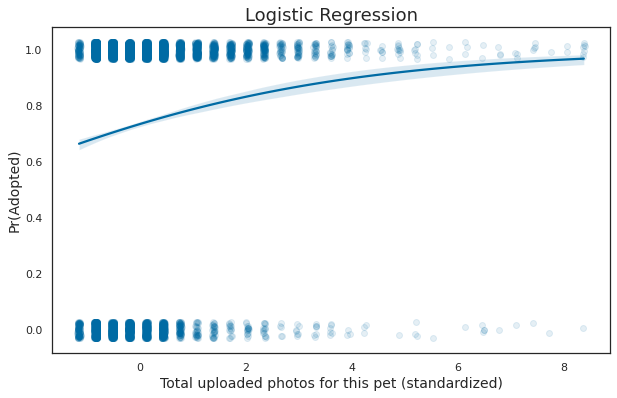

In [ ]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.regplot.html

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='PhotoAmt', y='Adopted', data=train_features.join(pd.Series(train_labels, name='Adopted')), 
            logistic=True, n_boot=500, x_jitter=.03, y_jitter=.03, 
            scatter_kws={'alpha': 0.10}, # Set transparency to 10%
            ax=ax)
ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total uploaded photos for this pet (standardized)', fontsize=14)
ax.set_title('Logistic Regression', fontsize=18);

In [ ]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

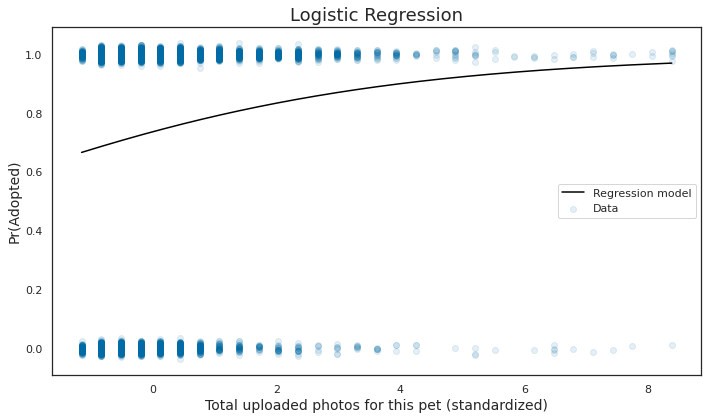

In [ ]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(train_features['PhotoAmt'].min(), train_features['PhotoAmt'].max(), 1000)
y = res_sm.predict(pd.DataFrame({'const': 1, 'PhotoAmt': x}))
f = interp1d(x, y, kind = "cubic")
xnew = np.linspace(train_features['PhotoAmt'].min(), train_features['PhotoAmt'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(train_features['PhotoAmt'], rand_jitter(train_labels), alpha=0.1, label='Data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total uploaded photos for this pet (standardized)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

In [ ]:
X_test = test_features['PhotoAmt'].values
X_test = sm.add_constant(X_test)

X_test[:10]

array([[ 1.        , -0.83447393],
       [ 1.        , -0.5154795 ],
       [ 1.        ,  2.35547032],
       [ 1.        , -0.83447393],
       [ 1.        ,  0.44150377],
       [ 1.        ,  0.44150377],
       [ 1.        , -0.19648508],
       [ 1.        , -0.19648508],
       [ 1.        , -0.5154795 ],
       [ 1.        ,  0.44150377]])

In [ ]:
y_pred_probs = res_sm.predict(exog=X_test)

y_pred_probs[:10]

array([0.6862113 , 0.70600295, 0.84791034, 0.6862113 , 0.76075101,
       0.76075101, 0.72504645, 0.72504645, 0.70600295, 0.76075101])

In [ ]:
y_preds = list(map(round, y_pred_probs))

y_preds[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
cm = confusion_matrix(test_labels, y_preds) 
print("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[   0  611]
 [   0 1696]]


In [ ]:
print(classification_report(test_labels, y_preds, target_names=['Not Adopted', 'Adopted']))

              precision    recall  f1-score   support

 Not Adopted       0.00      0.00      0.00       611
     Adopted       0.74      1.00      0.85      1696

    accuracy                           0.74      2307
   macro avg       0.37      0.50      0.42      2307
weighted avg       0.54      0.74      0.62      2307



In [ ]:
test_accuracy_sm = accuracy_score(test_labels, y_preds)
print('Test set (aka out-of-sample) Accuracy: {:.3f}'.format(test_accuracy_sm))

Test set (aka out-of-sample) Accuracy: 0.735


In [ ]:
test_precision_sm = precision_score(test_labels, y_preds)
print('Test set (aka out-of-sample) Precision: {:.3f}'.format(test_precision_sm))

Test set (aka out-of-sample) Precision: 0.735


In [ ]:
test_recall_sm = recall_score(test_labels, y_preds)
print('Test set (aka out-of-sample) Recall: {:.3f}'.format(test_recall_sm))

Test set (aka out-of-sample) Recall: 1.000


### `scikit-learn`

In [ ]:
y = train_labels.values

X = train_features['PhotoAmt'].values
X = sm.add_constant(X)

X.shape, y.shape

((9230, 2), (9230,))

In [ ]:
lr = LogisticRegression(penalty='none', fit_intercept=False)

res_sk = lr.fit(X, y)

res_sk

LogisticRegression(fit_intercept=False, penalty='none')

In [ ]:
coefs = [np.round(val, 4) for val in res_sk.coef_.flatten()]

ols_coefs = pd.DataFrame.from_dict( dict(zip(['Intercept', 'PhotoAmt'], coefs)), orient='index')
ols_coefs.columns = ['coef']

ols_coefs

,coef
Intercept,1.0273
PhotoAmt,0.2934


In [ ]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(test_features['PhotoAmt'].min(), test_features['PhotoAmt'].max(), 1000)
y = res_sm.predict(pd.DataFrame({'const': 1, 'PhotoAmt': x}))
f = interp1d(x, y, kind = "cubic")
xnew = np.linspace(train_features['PhotoAmt'].min(), train_features['PhotoAmt'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(train_features['PhotoAmt'], rand_jitter(train_labels), alpha=0.1, label='Data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total uploaded photos for this pet (standardized)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

In [ ]:
X_test = test_features['PhotoAmt'].values
X_test = sm.add_constant(X_test)

X_test[:10]

array([[ 1.        , -0.83447393],
       [ 1.        , -0.5154795 ],
       [ 1.        ,  2.35547032],
       [ 1.        , -0.83447393],
       [ 1.        ,  0.44150377],
       [ 1.        ,  0.44150377],
       [ 1.        , -0.19648508],
       [ 1.        , -0.19648508],
       [ 1.        , -0.5154795 ],
       [ 1.        ,  0.44150377]])

In [ ]:
res_sk.classes_

array([0, 1])

In [ ]:
# The returned estimates for all classes are ordered by the label of classes: res_sk.classes_

y_pred_probs = res_sk.predict_proba(X_test)

y_pred_probs[:10]

array([[0.31378865, 0.68621135],
       [0.293997  , 0.706003  ],
       [0.15208961, 0.84791039],
       [0.31378865, 0.68621135],
       [0.23924893, 0.76075107],
       [0.23924893, 0.76075107],
       [0.27495349, 0.72504651],
       [0.27495349, 0.72504651],
       [0.293997  , 0.706003  ],
       [0.23924893, 0.76075107]])

In [ ]:
y_preds = res_sk.predict(X_test)

y_preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cm = confusion_matrix(test_labels, y_preds) 
print("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[   0  611]
 [   0 1696]]


In [ ]:
print(classification_report(test_labels, y_preds, target_names=['Not Adopted', 'Adopted']))

              precision    recall  f1-score   support

 Not Adopted       0.00      0.00      0.00       611
     Adopted       0.74      1.00      0.85      1696

    accuracy                           0.74      2307
   macro avg       0.37      0.50      0.42      2307
weighted avg       0.54      0.74      0.62      2307



In [ ]:
test_accuracy_sk = accuracy_score(test_labels, y_preds)
print('Test set (aka out-of-sample) Accuracy: {:.3f}'.format(test_accuracy_sk))

Test set (aka out-of-sample) Accuracy: 0.735


In [ ]:
test_precision_sk = precision_score(test_labels, y_preds)
print('Test set (aka out-of-sample) Precision: {:.3f}'.format(test_precision_sk))

Test set (aka out-of-sample) Precision: 0.735


In [ ]:
test_recall_sk = recall_score(test_labels, y_preds)
print('Test set (aka out-of-sample) Recall: {:.3f}'.format(test_recall_sk))

Test set (aka out-of-sample) Recall: 1.000


### `tensorflow`

In [30]:
dataframe = pd.read_csv(csv_file)
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [31]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [32]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [33]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


Create a utility function that converts each training and test set DataFrame into a `tf.data.Dataset`, then shuffles and batches the data.

In [34]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

For each numeric feature in the dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [35]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the `tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup`, and `tf.keras.CategoryEncoding` preprocessing layers:

In [36]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

Create an input pipeline with a batch size of 256:

In [37]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

Normalize the numerical features (the number of pet photos and the adoption fee), and add them to one list of inputs called `encoded_features`:

In [38]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

Turn the integer categorical values from the dataset (the pet age) into integer indices, perform multi-hot encoding, and add the resulting feature inputs to `encoded_features`:

In [39]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

Repeat the same step for the string categorical values:

In [40]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

Create a model using the `Keras Functional API`. For the first layer in your model, merge the list of feature inputs — `encoded_features` — into one vector via concatenation with `tf.keras.layers.concatenate`.

In [41]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

Configure the model with `Keras Model.compile`:

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Visualize the connectivity graph:

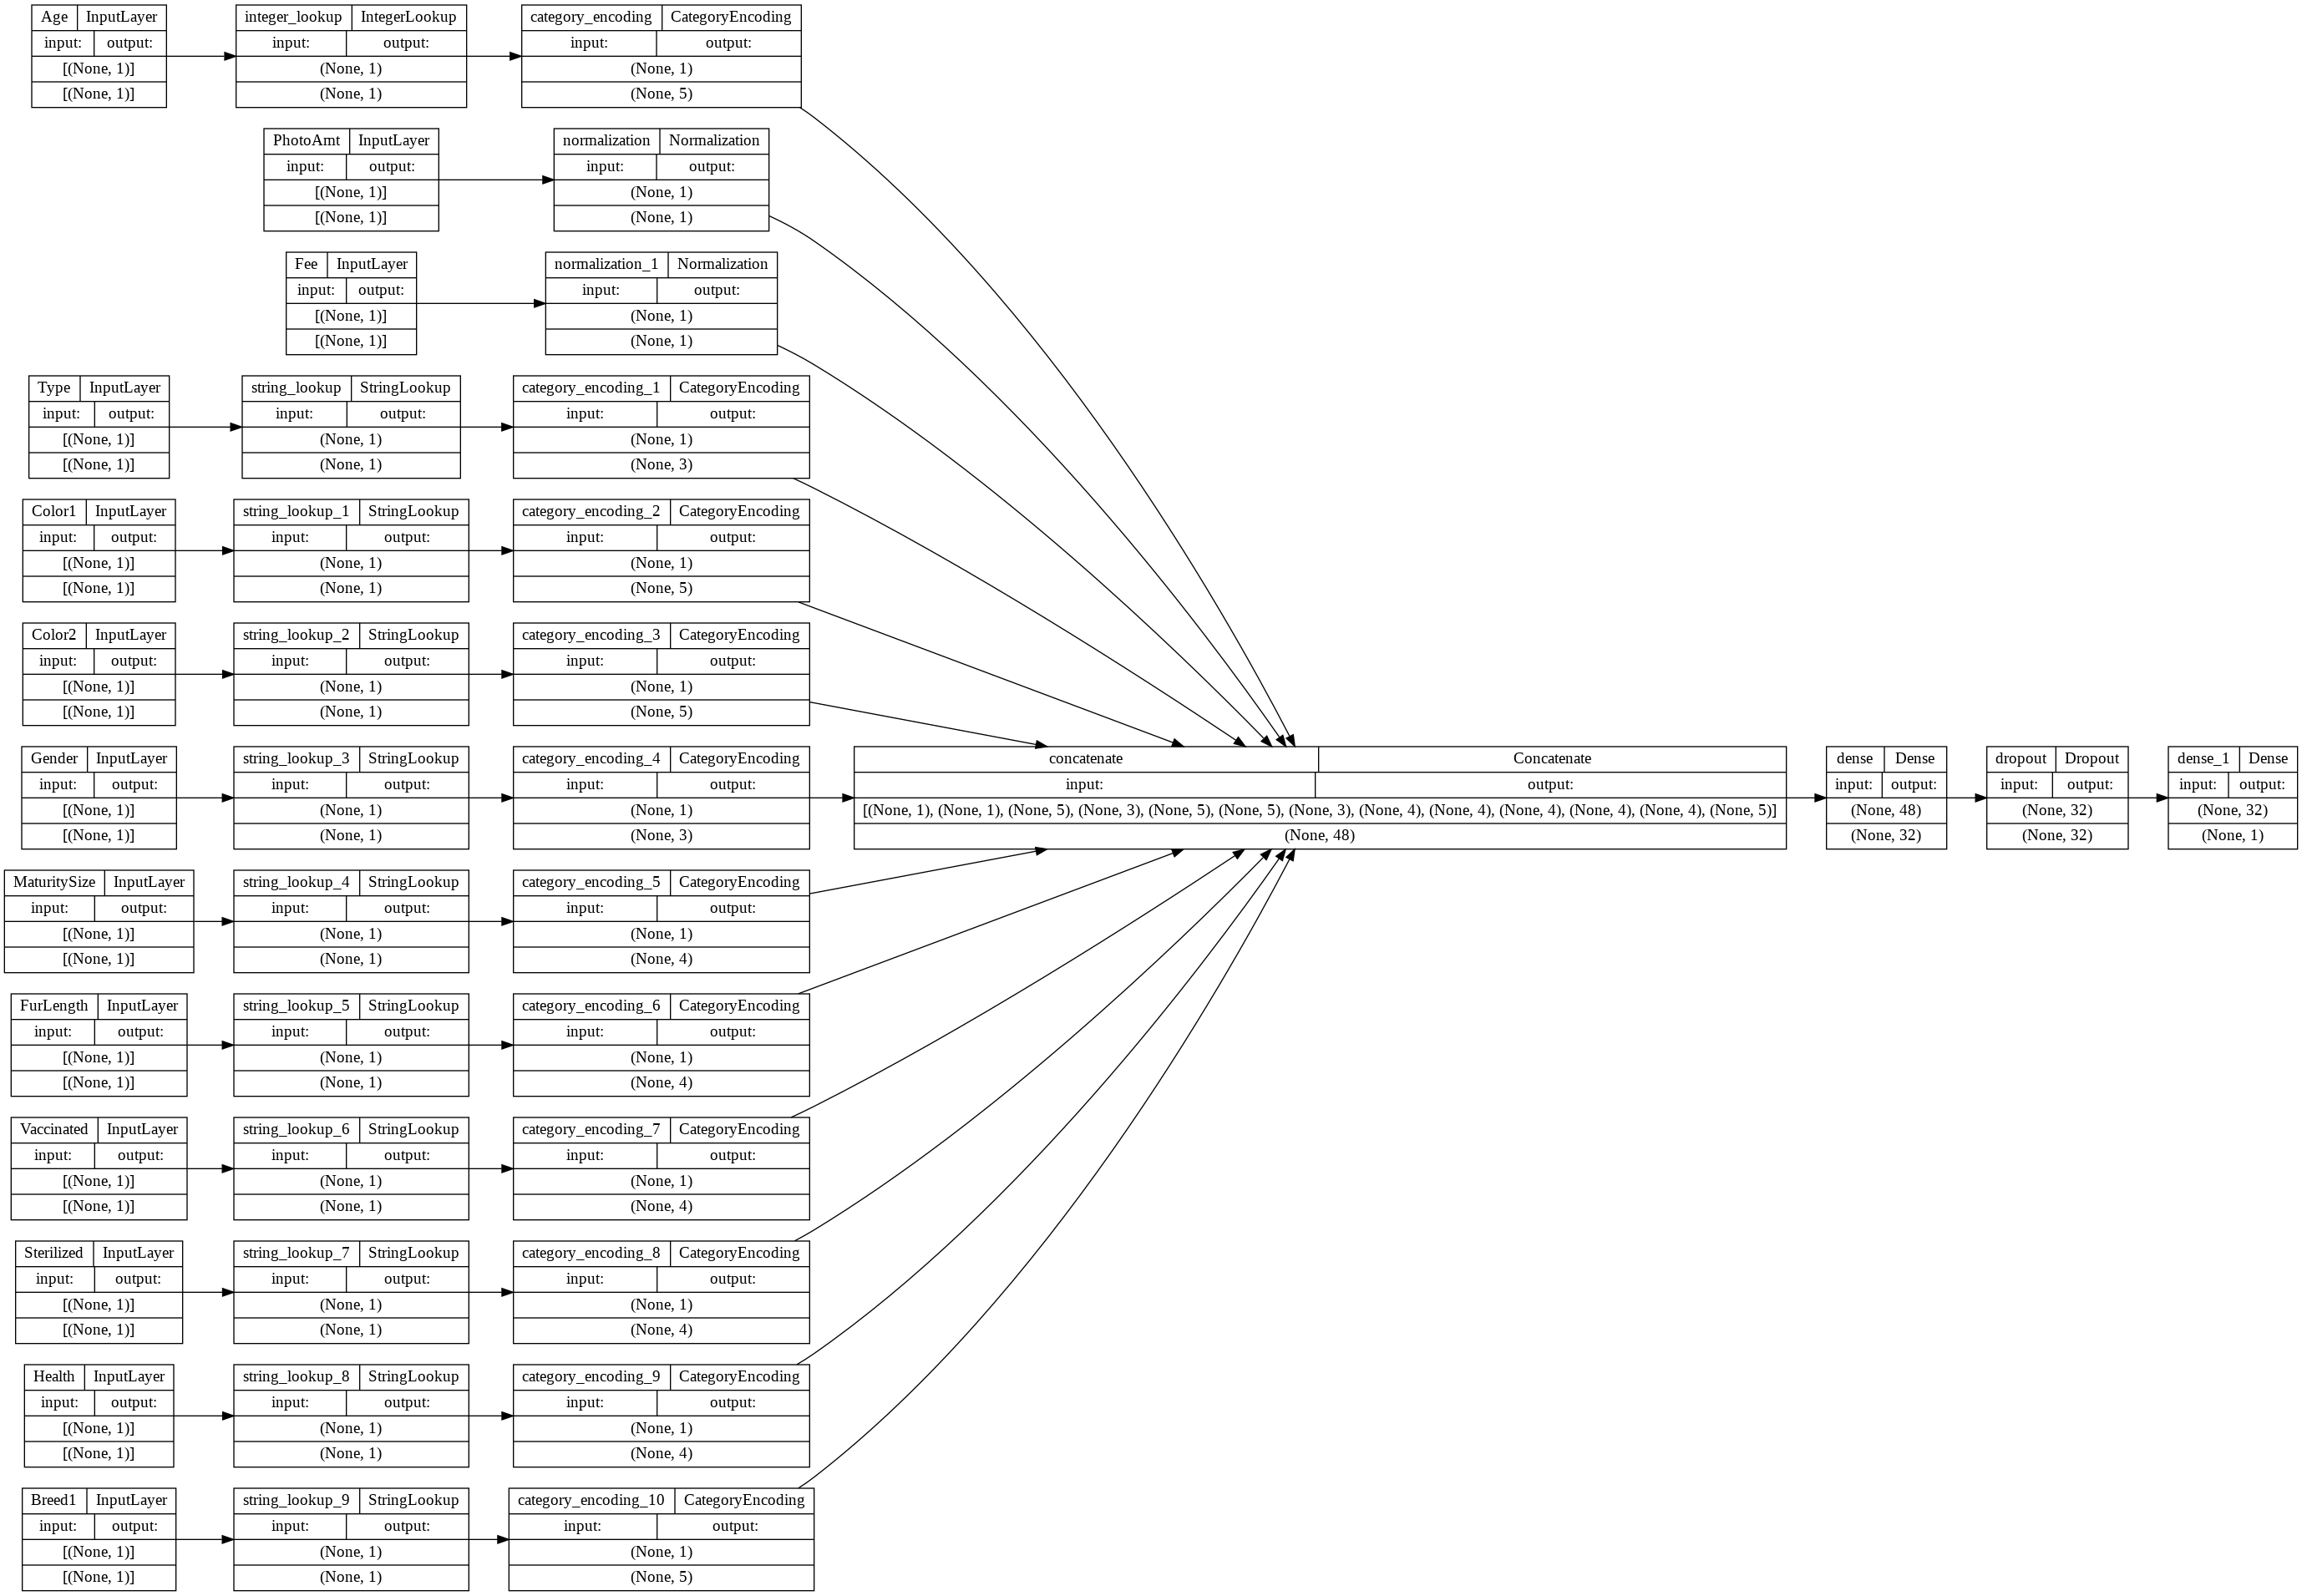

In [61]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Next, train and test the model:

In [62]:
baseline_history = model.fit(train_ds, epochs=10, validation_data=val_ds)
baseline_history

Epoch 1/10
37/37 [==============================] - 2s 18ms/step - loss: 0.5163 - accuracy: 0.7284 - val_loss: 0.5150 - val_accuracy: 0.7322
Epoch 2/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5129 - accuracy: 0.7319 - val_loss: 0.5144 - val_accuracy: 0.7409
Epoch 3/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5101 - accuracy: 0.7349 - val_loss: 0.5127 - val_accuracy: 0.7305
Epoch 4/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5058 - accuracy: 0.7421 - val_loss: 0.5128 - val_accuracy: 0.7340
Epoch 5/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5080 - accuracy: 0.7362 - val_loss: 0.5124 - val_accuracy: 0.7314
Epoch 6/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5077 - accuracy: 0.7396 - val_loss: 0.5116 - val_accuracy: 0.7305
Epoch 7/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5038 - accuracy: 0.7372 - val_loss: 0.5113 - val_accuracy: 0.7348
Epoch 8/10
37/37 [=

In [63]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", np.round(accuracy, 3))

5/5 [==============================] - 0s 5ms/step - loss: 0.5265 - accuracy: 0.7409
Accuracy 0.741


You can now save and reload the Keras model with `Model.save` and `Model.load_model` before performing inference on new data:

In [ ]:
model.save('/content/my_pet_classifier')
reloaded_model = tf.keras.models.load_model('/content/my_pet_classifier')

INFO:tensorflow:Assets written to: /content/my_pet_classifier/assets


INFO:tensorflow:Assets written to: /content/my_pet_classifier/assets


To get a prediction for a new sample, you can simply call the Keras `Model.predict` method. There are just two things you need to do:

1. Wrap scalars into a list so as to have a batch dimension (`Model`s only process batches of data, not single samples).

2. Call `tf.convert_to_tensor` on each feature.

In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

This particular pet had a 70.4 percent probability of getting adopted.


## Compare `statsmodels`, `scikit-learn`, and `tensorflow`

In [ ]:
pd.DataFrame([[test_accuracy_sm, test_precision_sm, test_recall_sm],
              [test_accuracy_sk, test_precision_sk, test_recall_sk],
              [accuracy, np.nan, np.nan]],
             index=['statsmodels', 'scikit-learn', 'tensorflow'],
             columns=['Accuracy', 'Precision', 'Recall']).round(2)

,Accuracy,Precision,Recall
statsmodels,0.74,0.74,1.0
scikit-learn,0.74,0.74,1.0
tensorflow,0.74,NaN,NaN
